# Produccion eléctrica en base a la metereología

La idea principal del trabajo es ser capaces de predecir como va a afectar a la produccion eléctrica de energias renovables y no renovables las precipitaciones, el viento y las horas de sol.
Como las horas de sol y el viento son fenomenos cuya causa efecto en principio es prácticamente inmediato, también vamos a centrarnos en la produccion de energia hidroelectrica para poder medir cuanto tiempo tarda en afectar a este tipo de energía las precipitaciones..

En base a esto tenemos varias cuestiones que queremos despejar:
- Que relación hay entre precipitaciones y el aumento de la generación de energia eléctrica hidráulica.
- Que relación hay entre horas de sol, temperatura y el aumento de la generación de energia eléctrica sólar.
- Que relación hay entre viento y el aumento de la generación de energia eléctrica eólica, esta relación esta condicionada por la temperatura, percipitaciones o horas de sol.
- Cuantos días tarda en aumentar la generación eléctrica de fuentes de energía renovables en función de los fenomenos metereológicos.
- Dados una prediccion meteorologica que valores de generación eléctrica tendremos para una fecha determinada.



Como premisas partimos de :
- Vamos a considerar solo el poll de energia que proporciona Red Electrica de España (REE)
- Vamos a considerar que las empresas no trabajan bajo mala praxis y que intentan optimizar el uso de energias renovables.
- Debido a la falta de datos a nivel diario de REE por provincia o comunidades autonomas, voy a centrar el analisis a nivel de sistema eléctrico (Peninsula, Baleares, Canarias ,Ceuta y Melilla).

Como origenes de datos para el estudio vamos a utilizar los datos proporcionados por:
- Información de REE (https://www.ree.es/es/apidatos) obtenida mediante su API.
- Datos proporcionados por aemet(https://opendata.aemet.es/centrodedescargas/inicio), vamos a utilizar la libreria  aemet desarrollada por Pablo Moreno (https://pypi.org/project/python-aemet/).

Requisitos para la ejecución del notebook:

Como requisitos para la ejecución del proyecto es necesario la instalación de la libreria python Aemet(pip install python-aemet) e instalar la libreria request.

Además las versiones de cada libreria utilizada en este proyecto son:

El modelo ha utilizar al tratarse de una prediccion númerica y no de obtener una etiqueta, sera una regresión.
Para poder llevar a cabo esa regresion se han pasado los valores de fechas a númericos, y se ha creado una columna por cada tipo de energia, creando varias variables objetivo.



In [131]:
# If the code is executed from Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/TFM_Generacion_electrica_AEMET/Python

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/TFM_Generacion_electrica_AEMET/Python'
/content/drive/My Drive/TFM_Generacion_electrica_AEMET/Python


In [132]:
# Instalacion libreria AEMET para ingesta de datos
!pip install python-aemet

In [133]:
from Lectura_AEMET_REE import Ingestion_AEMET,Ingestion_REE
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

Ing_AEMET=Ingestion_AEMET()

Ing_REE=Ingestion_REE()

pd.options.display.max_columns=None
plt.style.use('ggplot')




In [134]:
# put this in an input sentence
date_ini="2016-01-01T00:00:00UTC"
date_end="2021-12-31T00:00:00UTC"

# 1- Read data from API

###  Lectura datos AEMET <a id='From_api'></a>

Para la lectura de datos metereólogicos, vamos a utilizar la libreria aemet, de la que utilizaremos los metodos de las clases Aemet y Estacion para obtener los datos a nivel diario de cada estación meterologica para un rago de fechas, de las provincias que nos interesan para el estudio.<a id='From_api'></a>

In [135]:
#df_weather=Ing_AEMET.read_weather_dates(date_ini,date_end)

### Lectura de los datos de REE

Para la lectura de los datos de REE voy a utilizar la libreria python requests para a traves de su API, obtener la generación de electricidad en , para cada tipo de energia Electrica.

Una vez leidos los datos de la API, guardo los datos en formato json en un fichero. para no tener que repetir las consultas y poder trabajar sin conexion.

La estrutura de los datos leidos de REE es la siguiente:


Por lo que vamos a almacenar 2 ficheros:
    - Renovables
    - No Renovables



In [136]:
#df_ree=Ing_REE.read_ree_dates(date_ini,date_end)

### Saving Data to CSV

Para evitar tener que leer todos los datos en cada ejecucion, guardamos los en formato csv desde los DataFrame de REE y AEMET

In [137]:
#Ing_AEMET.save_to_csv(df_weather)

#Ing_REE.save_to_csv(df_ree) 

# 2- Reading data from CSV<a id='From_csv'></a>

In [138]:
df_weather=Ing_AEMET.read_from_csv()
df_ree=Ing_REE.read_from_csv()

In [139]:
df_ree.head()

,value,percentage,datetime,title,type,system
0,29281.000,0.054518,2016-01-01T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
1,35544.881,0.057414,2016-01-02T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
2,35910.705,0.054150,2016-01-03T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
3,65268.886,0.097287,2016-01-04T00:00:00.000+01:00,Hidráulica,Renovable,peninsular
4,79718.832,0.111964,2016-01-05T00:00:00.000+01:00,Hidráulica,Renovable,peninsular


In [140]:
df_weather.head()

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2016-01-01,0252D,ARENYS DE MAR,BARCELONA,74,"11,2","0,2","7,8",06:20,"14,7",12:40,24.0,"1,7","7,2",14:00,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,0252D,ARENYS DE MAR,BARCELONA,74,"11,8","0,0","7,5",23:40,"16,1",13:10,24.0,"1,1","9,7",11:40,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,0252D,ARENYS DE MAR,BARCELONA,74,"10,0","0,0","5,8",05:50,"14,1",13:20,24.0,"1,9","9,2",16:00,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,0252D,ARENYS DE MAR,BARCELONA,74,"11,6","0,9","8,0",22:50,"15,3",10:10,32.0,"0,8","8,9",02:40,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,0252D,ARENYS DE MAR,BARCELONA,74,"9,9","0,1","5,6",23:59,"14,2",12:30,32.0,"2,5","8,6",17:30,NaN,NaN,NaN,NaN,NaN


## Limpieza datos AEMET


In [141]:
def limpieza(df,cols):
    for element in cols:
        df[element]=df[element].str.replace(',', '.')
        df[element]=pd.to_numeric(df[element],errors='coerce')
    return df

# Elimino las columnas que no me interesan
df_weather.drop(columns=['altitud','horaPresMax','horaPresMin','horaracha','dir','horatmin','horatmax'],inplace=True)

df_weather=limpieza(df_weather,df_weather.columns[5:])


In [142]:
# Gropued by provincia and fecha
df_weather_mean=df_weather.groupby(['provincia','fecha'],as_index=False)['prec','tmed','sol','velmedia'].mean()
df_weather_max=df_weather.groupby(['provincia','fecha'],as_index=False)['tmax','presMax','racha'].max()
df_weather_min=df_weather.groupby(['provincia','fecha'],as_index=False)['tmin','presMin'].min()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [143]:
# Union of the 3 datasets by provincia and fecha
df_weather_group=pd.merge(df_weather_mean,df_weather_max, how='inner', on=['provincia','fecha'])
df_weather=pd.merge(df_weather_min,df_weather_group, how='inner', on=['provincia','fecha'])

In [144]:
''' Creo una funcion que pase los indicadores a float 
y rellene los valores vacios por la media de las estaciones de esa provincia para ese dia'''

def rellena_nulos_provincia(df,cols):
    
    # Defino un DataFrame vacio para acumular el resultado
    df_all=pd.DataFrame()
    
    #Dataframe auxiliar para tener todas las provincias y dias para iterar
    df_aux=df_weather[['provincia','fecha']].drop_duplicates()
    
    # Hago un bucle para cada provincia y dia del DataFrame de entrada para ir tratando los datos a ese nivel.
    for prov,fecha in tqdm(df_aux.values):
        df_prov=[]
        df_prov=df[(df['provincia']==prov) & (df['fecha']==fecha)]
        
        #Para cada elemento de las columnas que nos interesan reemplazo , por ., paso a numerico y relleno los nulos por la media de la provincia
        for element in cols:
            df_prov[element]=df_prov[element].str.replace(',', '.')
            df_prov[element]=pd.to_numeric(df_prov[element],errors='coerce')
            #df_prov[element].fillna(df_prov[element].mean(skipna=True),inplace=True)
        df_all=df_all.append(df_prov)
    return df_all


In [145]:
electric_systems={
    'STA. CRUZ DE TENERIFE':'canarias',
    'LAS PALMAS':'canarias',
    'ILLES BALEARS':'baleares',
    'CEUTA':'ceuta',
    'MELILLA':'melilla'}

# Now each provincia have the same weigth in the DataFrame, we need to agrup by electric system to join the data after.

df_weather['system']=[electric_systems[l.upper()]  
                      if l.upper() in electric_systems.keys() else 'peninsular' 
                      for l in df_weather['provincia'] ]

weather_grouped=df_weather.groupby(['fecha','system'],as_index=False)
df_weather_system=weather_grouped.mean(['tmed','prec','tmin','tmax','velmedia','sol','presMax','presMin','racha'])
df_weather_system

,fecha,system,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha
0,2016-01-01,baleares,3.300000,1009.300000,0.022222,1.940000,2.366667,18.900000,1024.900000,14.200000
1,2016-01-01,canarias,7.900000,894.700000,0.000000,9.266667,2.781667,24.250000,1025.450000,10.400000
2,2016-01-01,ceuta,13.800000,1012.400000,0.000000,7.600000,1.400000,21.200000,1015.400000,10.800000
3,2016-01-01,melilla,10.600000,1016.600000,0.000000,9.100000,1.700000,20.400000,1019.900000,5.600000
4,2016-01-01,peninsular,3.817021,921.165957,5.477102,2.231907,3.189763,16.440426,984.380851,16.361702
...,...,...,...,...,...,...,...,...,...,...
9715,2021-04-27,baleares,7.100000,994.500000,0.000000,5.766667,2.800000,22.200000,1007.100000,13.600000
9716,2021-04-27,canarias,10.050000,884.550000,0.027778,5.458333,2.862500,25.400000,1012.700000,11.250000
9717,2021-04-27,ceuta,15.800000,996.800000,5.600000,4.800000,2.500000,20.700000,998.800000,11.100000
9718,2021-04-27,melilla,14.800000,1000.700000,0.000000,11.900000,2.800000,25.500000,1003.500000,10.600000


## Limpieza de datos de REE

In [146]:
Renovable_system=pd.unique(df_ree[df_ree['type']=='Renovable']['system'])
df_ree_renov=df_ree[df_ree['system'].isin(Renovable_system)]

In [147]:
# Renombro los campos
df_ree_renov.rename(columns={'value':'Generacion_Mwh','title':'Tecnologia','type':'Renov_norenov'},inplace=True)

# Elimino la columna percentage por ser una columna generada de Generacion_Mwh.
df_ree_renov.drop('percentage',axis=1,inplace=True)

# Cambio los valores nulos de Generacion en Mwh por 0
df_ree_renov['Generacion_Mwh'].fillna(0)

# Elimino las filas para las cuales la fecha es nula y paso la fecha a formato corto.
df_ree_renov['fecha']=df_ree_renov['datetime'].str[:10]
df_ree_renov=df_ree_renov[~df_ree_renov['fecha'].isna()]
df_ree_renov.drop(['datetime'],axis=1,inplace=True)
df_ree_renov.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added b

,Generacion_Mwh,Tecnologia,Renov_norenov,system,fecha
0,29281.000,Hidráulica,Renovable,peninsular,2016-01-01
1,35544.881,Hidráulica,Renovable,peninsular,2016-01-02
2,35910.705,Hidráulica,Renovable,peninsular,2016-01-03
3,65268.886,Hidráulica,Renovable,peninsular,2016-01-04
4,79718.832,Hidráulica,Renovable,peninsular,2016-01-05


# Electric generation features analysis

## Total Generation

In [148]:
def plot_generacion(df,tech,system,fecini_zoom,fecfin_zoom,c='r'):
 
  f,ax=plt.subplots(1,1)
  f.set_size_inches(18,6)
  f.suptitle('Evolución de la generacion (Mwh) por fecha', fontsize=20)
 
  filter1=(df['Tecnologia'].isin(tech)) & (df['system']==system)
 
  ax.plot(df[filter1]['fecha'],df[filter1]['Generacion_Mwh'],c,alpha=0.6)
  ax.set_xticklabels([])
  ax.set_title(system.upper(),fontsize=14)
  ax.set_xlabel('Fecha')
  ax.set_ylabel('Mwh')
    
  title_zoom='Zoom: from '+fecini_zoom+' to '+ fecfin_zoom
  filter2=filter1 & (df['fecha']>=fecini_zoom) & (df['fecha']<=fecfin_zoom)
  ax_zoom=f.add_axes([.63,.13,.25,.2])
  ax_zoom.plot(df[filter2]['fecha'],df[filter2]['Generacion_Mwh'],c,alpha=0.6)
  ax_zoom.set_xticklabels([])
  ax_zoom.set_title(title_zoom,fontsize=12)
  ax_zoom.set_ylabel('Mwh')
 
  return None

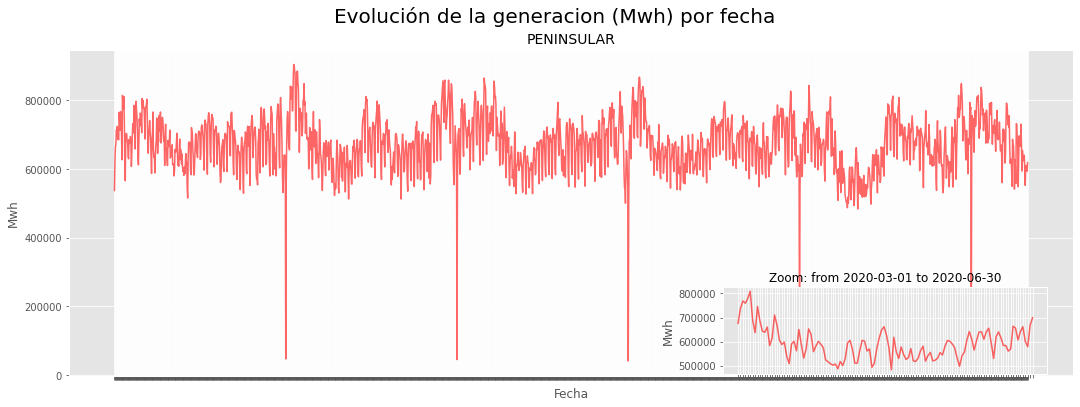

In [149]:
plot_generacion(df_ree_renov,['Generación total'],'peninsular','2020-03-01','2020-06-30')

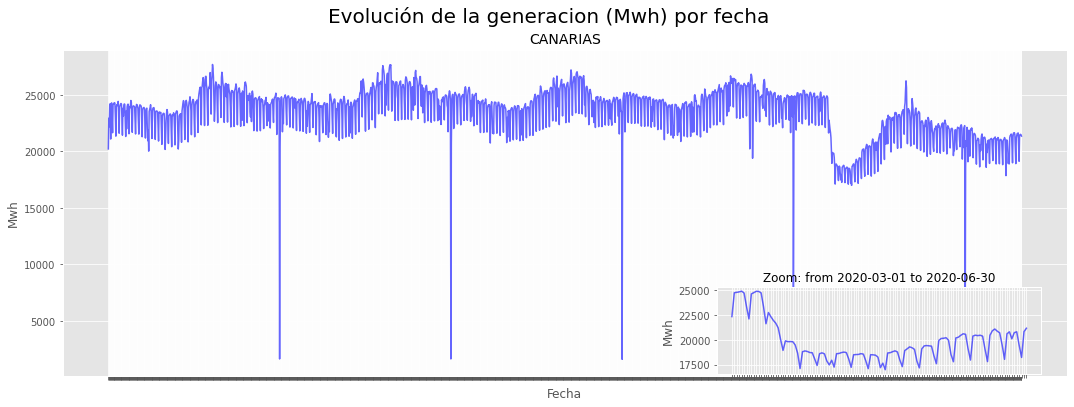

In [150]:
plot_generacion(df_ree_renov,['Generación total'],'canarias','2020-03-01','2020-06-30',c='b')

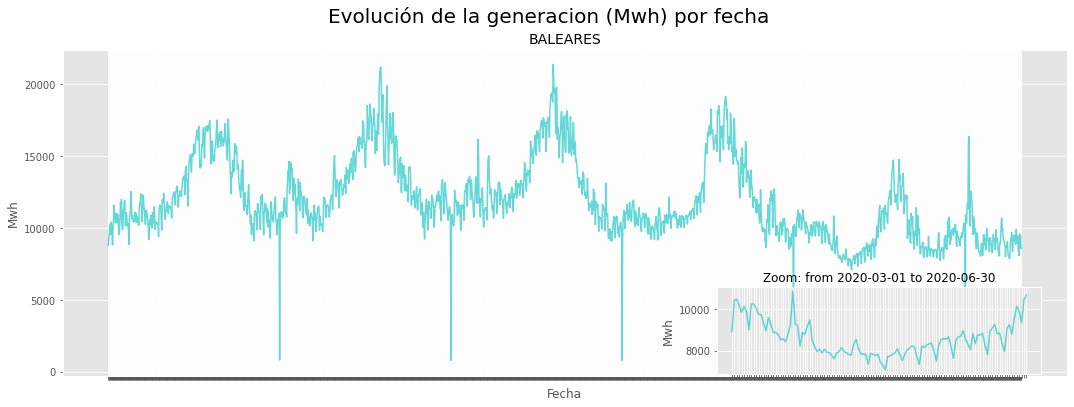

In [151]:
plot_generacion(df_ree_renov,['Generación total'],'baleares','2020-03-01','2020-06-30',c='c')

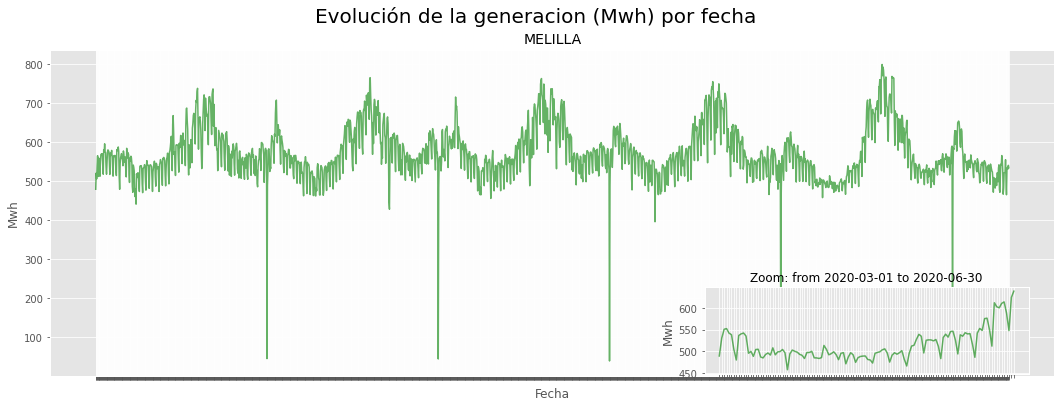

In [152]:
plot_generacion(df_ree_renov,['Generación total'],'melilla','2020-03-01','2020-06-30',c='g')

In [153]:
df_ree_filtered=df_ree_renov[(df_ree_renov['fecha']<'2020-03-15') | (df_ree_renov['fecha']>='2020-06-28')]

In [154]:
df_ree_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71391 entries, 0 to 574
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Generacion_Mwh  71391 non-null  float64
 1   Tecnologia      71391 non-null  object 
 2   Renov_norenov   71391 non-null  object 
 3   system          71391 non-null  object 
 4   fecha           71391 non-null  object 
dtypes: float64(1), object(4)
memory usage: 3.3+ MB


# Weather features analysis

## Precipitacions

In [155]:
df_weather_system['prec'].describe()

count    9631.000000
mean        1.366117
std         5.036793
min         0.000000
25%         0.000000
50%         0.000000
75%         0.493418
max       184.400000
Name: prec, dtype: float64

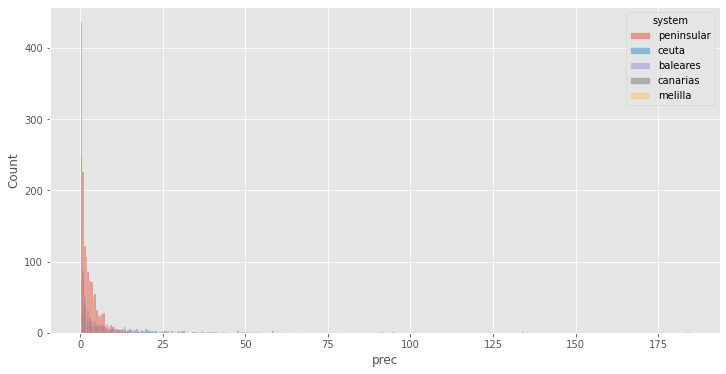

In [156]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.histplot(data=df_weather_system[df_weather_system['prec']>0.1],x='prec',hue='system',alpha=0.5);

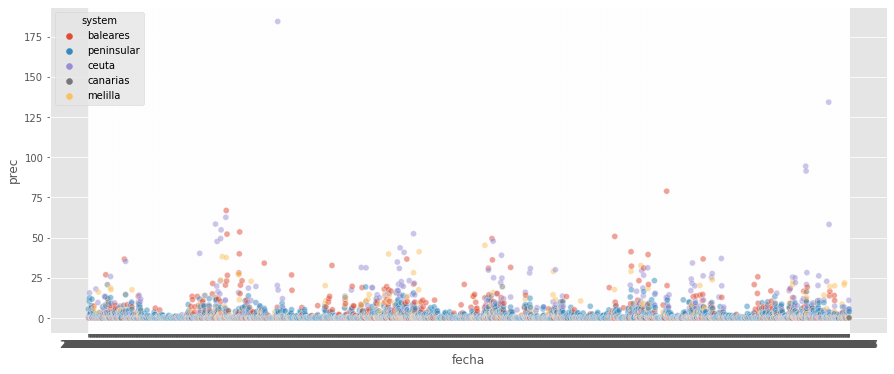

In [157]:
f,ax=plt.subplots(1,1)
f.set_size_inches(15,6)
ax=sns.scatterplot(data=df_weather_system[df_weather_system['prec']>0],y='prec',x='fecha',hue='system',alpha=0.5);

## Hours of sun

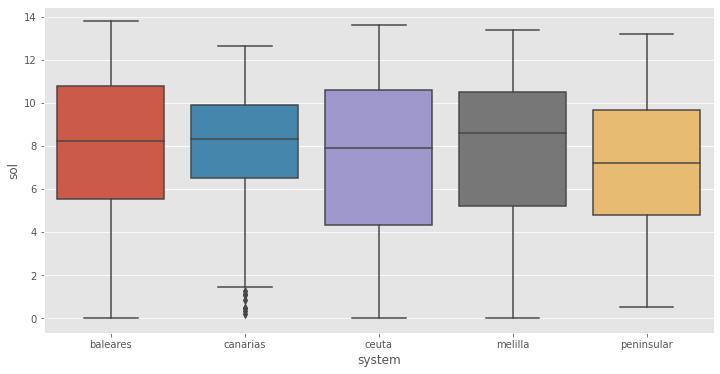

In [158]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='sol', data=df_weather_system);

In [159]:
df_weather_system['sol'].describe()

count    9714.000000
mean        7.627169
std         3.359610
min         0.000000
25%         5.377083
50%         8.083333
75%        10.200000
max        13.783333
Name: sol, dtype: float64

## Temperature

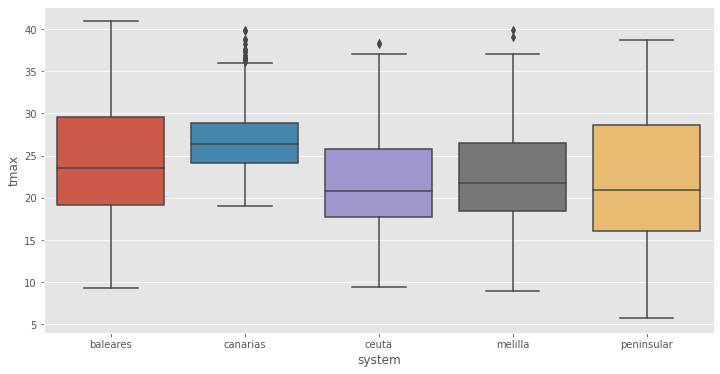

In [160]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='tmax', data=df_weather_system);

In [161]:
df_weather_system['tmax'].describe()

count    9714.000000
mean       23.551513
std         5.876357
min         5.765957
25%        18.800000
50%        23.550000
75%        27.918617
max        40.900000
Name: tmax, dtype: float64

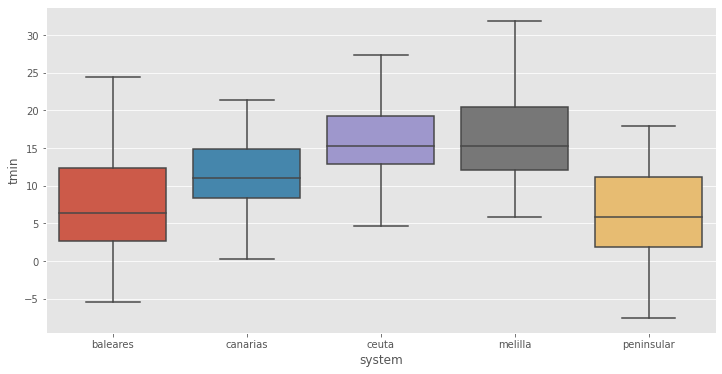

In [162]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='tmin', data=df_weather_system);

In [163]:
df_weather_system['tmin'].describe()

count    9714.000000
mean       11.460986
std         6.388128
min        -7.570213
25%         7.150000
50%        12.000000
75%        15.770213
max        31.800000
Name: tmin, dtype: float64

## Wind

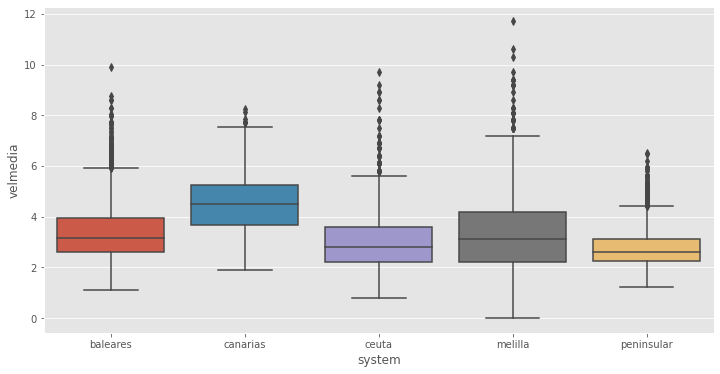

In [164]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='velmedia', data=df_weather_system);

In [165]:
df_weather_system['velmedia'].describe()

count    9715.000000
mean        3.389805
std         1.332605
min         0.000000
25%         2.461898
50%         3.100000
75%         4.200000
max        11.700000
Name: velmedia, dtype: float64

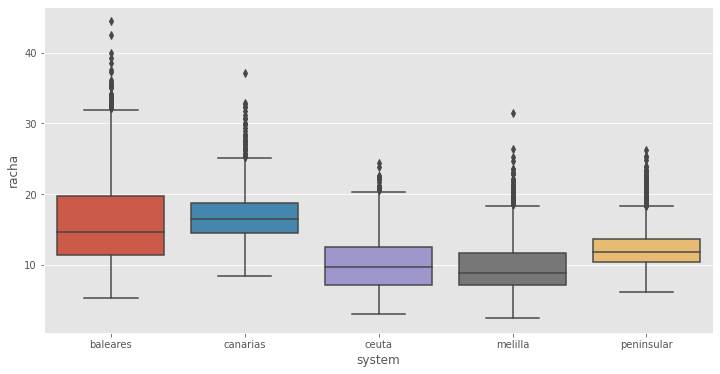

In [166]:
f,ax=plt.subplots(1,1)
f.set_size_inches(12,6)
ax=sns.boxplot(x='system',y='racha', data=df_weather_system);

In [167]:
df_weather_system['racha'].describe()

count    9711.000000
mean       13.021494
std         5.038201
min         2.500000
25%         9.503191
50%        12.210638
75%        16.055319
max        44.400000
Name: racha, dtype: float64

# Outliers

Vamos a buscar los outlier de precipitaciones y temperatura minima, por si fuesen datos erroneos.



### Outlier de Precipitaciones


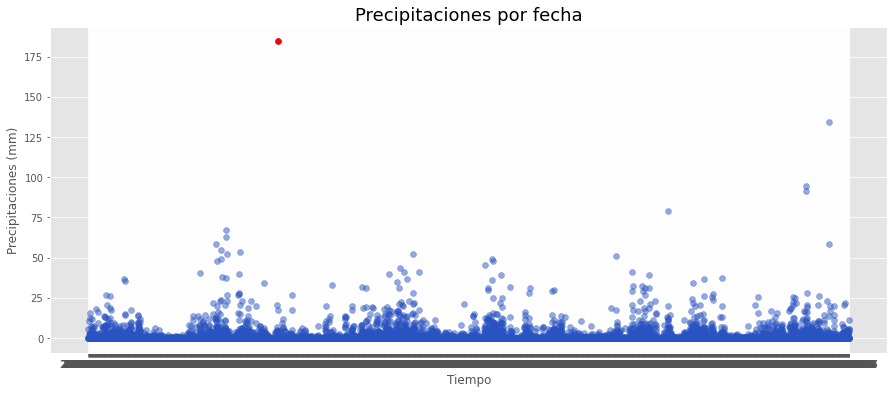

In [168]:

maxprec_mm=df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]['prec']
maxprec_fec=df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]['fecha']
plt.figure(figsize=(15,6))
plt.scatter(df_weather_system['fecha'],df_weather_system['prec'],c='#2953C2',alpha=0.5)
plt.scatter(maxprec_fec,maxprec_mm,c='r')
plt.title('Precipitaciones por fecha',fontsize=18)
plt.xlabel('Tiempo')
plt.ylabel('Precipitaciones (mm)')
plt.minorticks_off();


In [169]:
df_weather_system[df_weather_system['prec']==df_weather_system['prec'].max()]

,fecha,system,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha
2417,2017-04-28,ceuta,14.5,998.7,184.4,0.0,4.7,16.3,1002.7,11.9


### Outliers de Temperatura mínima

El 02-08-2020 tenemos un dato máximo en la serie histórica de temperaturas minimas de 31,8 grados en la estación de MELILLA

In [170]:
tminGrouped=df_weather_system.groupby('fecha')['tmin'].mean().reset_index()
maxtmin_celsius=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]['tmin']
maxtmin_fec=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]['fecha']
mintmin_celsius=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]['tmin']
mintmin_fec=df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]['fecha']

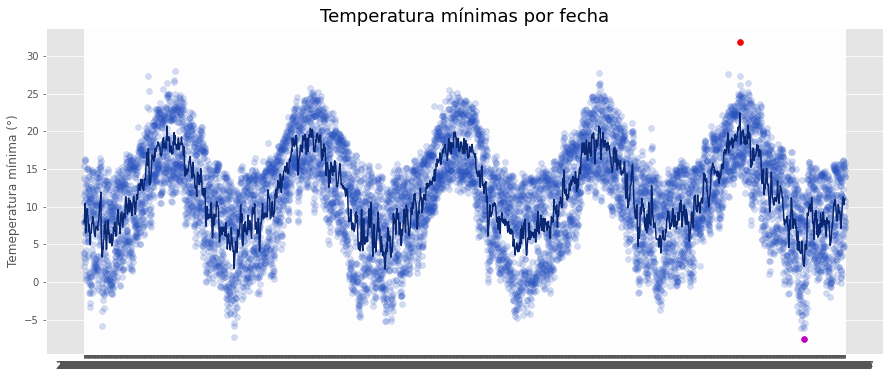

In [171]:

plt.figure(figsize=(15,6))
plt.plot(tminGrouped['fecha'],tminGrouped['tmin'],c='#0A2774')
plt.scatter(df_weather_system['fecha'],df_weather_system['tmin'],c='#2953C2',alpha=0.2)
plt.scatter(maxtmin_fec,maxtmin_celsius,c='r')
plt.scatter(mintmin_fec,mintmin_celsius,c='m')
plt.title('Temperatura mínimas por fecha',fontsize=18)
plt.ylabel('Tiempo')
plt.ylabel('Temeperatura mínima (°)');



In [172]:
df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].max()]

,fecha,system,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha
8378,2020-08-02,melilla,31.8,1005.7,0.0,12.1,4.7,39.1,1008.3,11.7


In [173]:
df_weather_system[df_weather_system['tmin']==df_weather_system['tmin'].min()]

,fecha,system,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha
9194,2021-01-12,peninsular,-7.570213,932.525532,0.022589,7.020053,1.827664,10.544681,989.948936,8.670213


### Outliers de Temperatura máxima

In [174]:
tmaxGrouped=df_weather_system.groupby('fecha')['tmax'].mean().reset_index()
maxtmax_celsius=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]['tmax']
maxtmax_fec=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]['fecha']
mintmax_celsius=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]['tmax']
mintmax_fec=df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]['fecha']

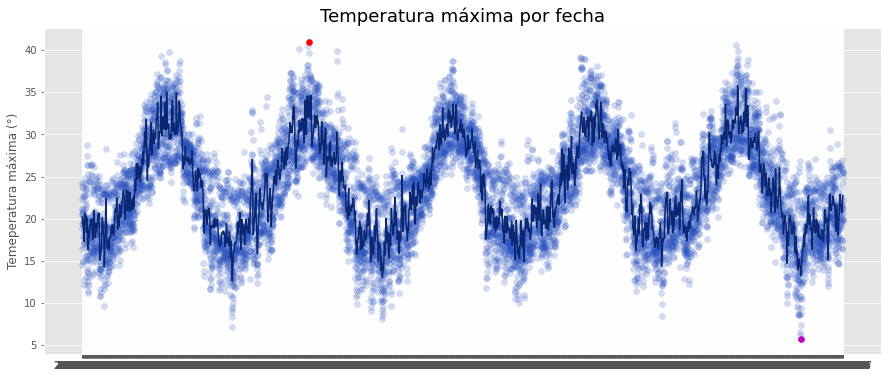

In [175]:
plt.figure(figsize=(15,6))
plt.plot(tmaxGrouped['fecha'],tmaxGrouped['tmax'],c='#0A2774')
plt.scatter(df_weather_system['fecha'],df_weather_system['tmax'],c='#2953C2',alpha=0.2)
plt.scatter(maxtmax_fec,maxtmax_celsius,c='r')
plt.scatter(mintmax_fec,mintmax_celsius,c='m')
plt.title('Temperatura máxima por fecha',fontsize=18)
plt.ylabel('Tiempo')
plt.ylabel('Temeperatura máxima (°)');


In [176]:
df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].max()]

,fecha,system,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha
2900,2017-08-03,baleares,21.0,1003.6,0.0,11.633333,2.77,40.9,1016.4,18.1


In [177]:
df_weather_system[df_weather_system['tmax']==df_weather_system['tmax'].min()]

,fecha,system,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha
9179,2021-01-09,peninsular,-2.704255,911.965957,5.777147,1.335106,3.284696,5.765957,968.923404,14.114894


# Features 

Frist I´m going to convert de REE Dataframe to a Array of array as target for the model. 
For this I get a onehotencoding DataFrame for Tecnology, Renov_norenov and system and then I multiply each tecnology by Generacion Mwh


In [178]:
df_ree=df_ree_filtered[df_ree_filtered['Renov_norenov']!='Generación total']

In [179]:
df_ree.reset_index(inplace=True,drop=True) #to join by index before encoding

## Encoder for categorical variables

In [180]:
from sklearn.preprocessing import OneHotEncoder

enc=OneHotEncoder().fit(df_ree[['Tecnologia','system','Renov_norenov']])

df_transform=enc.transform(df_ree[['Tecnologia','system','Renov_norenov']])

column_names=enc.get_feature_names()
df_onehot =  pd.DataFrame(df_transform.todense(), columns= column_names)

In [181]:
tech_names=[x for x in enc.get_feature_names() if x[0:3]=='x0_']
system_names=[x for x in enc.get_feature_names() if x[0:3]=='x1_']
renov_names=[x for x in enc.get_feature_names() if x[0:3]=='x2_']

In [182]:
print(tech_names)
print(system_names)
print(renov_names)

['x0_Carbón', 'x0_Ciclo combinado', 'x0_Cogeneración', 'x0_Eólica', 'x0_Fuel + Gas', 'x0_Hidroeólica', 'x0_Hidráulica', 'x0_Motores diésel', 'x0_Nuclear', 'x0_Otras renovables', 'x0_Residuos no renovables', 'x0_Residuos renovables', 'x0_Solar fotovoltaica', 'x0_Solar térmica', 'x0_Turbina de gas', 'x0_Turbina de vapor', 'x0_Turbinación bombeo']
['x1_baleares', 'x1_canarias', 'x1_melilla', 'x1_peninsular']
['x2_No-Renovable', 'x2_Renovable']


In [183]:
df_ree_onehot=pd.merge(df_ree[['Generacion_Mwh','fecha']],df_onehot,how='inner',left_index=True,right_index=True)

In [184]:

for column_tech in tech_names:
  df_ree_onehot[column_tech]=df_ree_onehot[column_tech]*df_ree_onehot['Generacion_Mwh']	

for column_renov in renov_names:
  df_ree_onehot[column_renov]=df_ree_onehot[column_renov]*df_ree_onehot['Generacion_Mwh']	

df_ree_target=df_ree_onehot.groupby(['fecha','x1_baleares','x1_canarias','x1_melilla','x1_peninsular'],as_index=False).sum()
#.drop('Generacion_Mwh',axis=1,inplace=True)

In [185]:
df_ree_target.head()

,fecha,x1_baleares,x1_canarias,x1_melilla,x1_peninsular,Generacion_Mwh,x0_Carbón,x0_Ciclo combinado,x0_Cogeneración,x0_Eólica,x0_Fuel + Gas,x0_Hidroeólica,x0_Hidráulica,x0_Motores diésel,x0_Nuclear,x0_Otras renovables,x0_Residuos no renovables,x0_Residuos renovables,x0_Solar fotovoltaica,x0_Solar térmica,x0_Turbina de gas,x0_Turbina de vapor,x0_Turbinación bombeo,x2_No-Renovable,x2_Renovable
0,2016-01-01,0.0,0.0,0.0,1.0,537090.081,24401.321,48452.794,41918.271,199437.416,0.0,0.000,29281.000,0.000,162745.220,7169.124,3848.0700,1179.2320,8179.808,695.552,0.000,0.000,9782.273,291147.9490,245942.1320
1,2016-01-01,0.0,0.0,1.0,0.0,479.011,0.000,0.000,0.000,0.000,0.0,0.000,0.000,447.061,0.000,0.000,15.9025,15.9025,0.145,0.000,0.000,0.000,0.000,462.9635,16.0475
2,2016-01-01,0.0,1.0,0.0,0.0,20220.015,0.000,7124.185,0.000,383.526,0.0,11.815,9.163,6026.826,0.000,26.995,0.0000,0.0000,697.304,0.000,160.570,5779.631,0.000,19091.2120,1128.8030
3,2016-01-01,1.0,0.0,0.0,0.0,8814.678,3032.187,2277.467,69.160,11.053,0.0,0.000,0.000,1022.316,0.000,1.362,485.0490,485.0490,144.200,0.000,1286.835,0.000,0.000,8173.0140,641.6640
4,2016-01-02,0.0,0.0,0.0,1.0,619096.702,28801.603,46225.570,53159.017,235393.376,0.0,0.000,35544.881,0.000,169614.296,7847.535,4097.2255,1139.0335,11752.604,1260.093,0.000,0.000,24261.468,326159.1795,292937.5225


###  Tratamiento de fechas

Para pasar las fechas aun formato en que el salto entre el ultimo dia de un mes y el primer dia del siguiente sea continuo, uso los cosenos de los dias y meses. 

Para ello situo los valores de los 31 dias en angulos iguales calulandolos como $Dia(x)=\cos\frac{2\pi}{31}x$

Del mismo modo para los meses situo cada mes en $Mes(x)=\cos\frac{2\pi}{12}x$

In [186]:
df_weather_system['year']=df_weather_system['fecha'].str.slice(0,4).astype(int)
df_weather_system['day']=df_weather_system['fecha'].str.slice(8,10)
df_weather_system['month']=df_weather_system['fecha'].str.slice(5,7)

In [187]:
df_weather_system['day_t']=np.cos(((2*np.pi)/31)*df_weather_system['day'].astype(int))
df_weather_system['month_t']=np.cos(((2*np.pi)/12)*df_weather_system['month'].astype(int))
df_weather_system

,fecha,system,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha,year,day,month,day_t,month_t
0,2016-01-01,baleares,3.300000,1009.300000,0.022222,1.940000,2.366667,18.900000,1024.900000,14.200000,2016,01,01,0.979530,0.866025
1,2016-01-01,canarias,7.900000,894.700000,0.000000,9.266667,2.781667,24.250000,1025.450000,10.400000,2016,01,01,0.979530,0.866025
2,2016-01-01,ceuta,13.800000,1012.400000,0.000000,7.600000,1.400000,21.200000,1015.400000,10.800000,2016,01,01,0.979530,0.866025
3,2016-01-01,melilla,10.600000,1016.600000,0.000000,9.100000,1.700000,20.400000,1019.900000,5.600000,2016,01,01,0.979530,0.866025
4,2016-01-01,peninsular,3.817021,921.165957,5.477102,2.231907,3.189763,16.440426,984.380851,16.361702,2016,01,01,0.979530,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,2021-04-27,baleares,7.100000,994.500000,0.000000,5.766667,2.800000,22.200000,1007.100000,13.600000,2021,27,04,0.688967,-0.500000
9716,2021-04-27,canarias,10.050000,884.550000,0.027778,5.458333,2.862500,25.400000,1012.700000,11.250000,2021,27,04,0.688967,-0.500000
9717,2021-04-27,ceuta,15.800000,996.800000,5.600000,4.800000,2.500000,20.700000,998.800000,11.100000,2021,27,04,0.688967,-0.500000
9718,2021-04-27,melilla,14.800000,1000.700000,0.000000,11.900000,2.800000,25.500000,1003.500000,10.600000,2021,27,04,0.688967,-0.500000


In [188]:
df_weather_system.drop(['month','day'],axis=1,inplace=True)

In [189]:
enc_system=OneHotEncoder().fit(df_weather_system[['system']])

df_transform_weather=enc_system.transform(df_weather_system[['system']])

column_weather=enc_system.get_feature_names(['x1'])

df_onehot_weather =  pd.DataFrame(df_transform_weather.todense(),columns=column_weather)

     
df_weather_features=pd.merge(df_weather_system,df_onehot_weather,left_index=True,right_index=True)                               
df_weather_features.drop('system',axis=1,inplace=True)
                               

In [190]:
df_weather_features.head()

,fecha,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha,year,day_t,month_t,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,2016-01-01,3.300000,1009.300000,0.022222,1.940000,2.366667,18.900000,1024.900000,14.200000,2016,0.97953,0.866025,1.0,0.0,0.0,0.0,0.0
1,2016-01-01,7.900000,894.700000,0.000000,9.266667,2.781667,24.250000,1025.450000,10.400000,2016,0.97953,0.866025,0.0,1.0,0.0,0.0,0.0
2,2016-01-01,13.800000,1012.400000,0.000000,7.600000,1.400000,21.200000,1015.400000,10.800000,2016,0.97953,0.866025,0.0,0.0,1.0,0.0,0.0
3,2016-01-01,10.600000,1016.600000,0.000000,9.100000,1.700000,20.400000,1019.900000,5.600000,2016,0.97953,0.866025,0.0,0.0,0.0,1.0,0.0
4,2016-01-01,3.817021,921.165957,5.477102,2.231907,3.189763,16.440426,984.380851,16.361702,2016,0.97953,0.866025,0.0,0.0,0.0,0.0,1.0


## Statistics

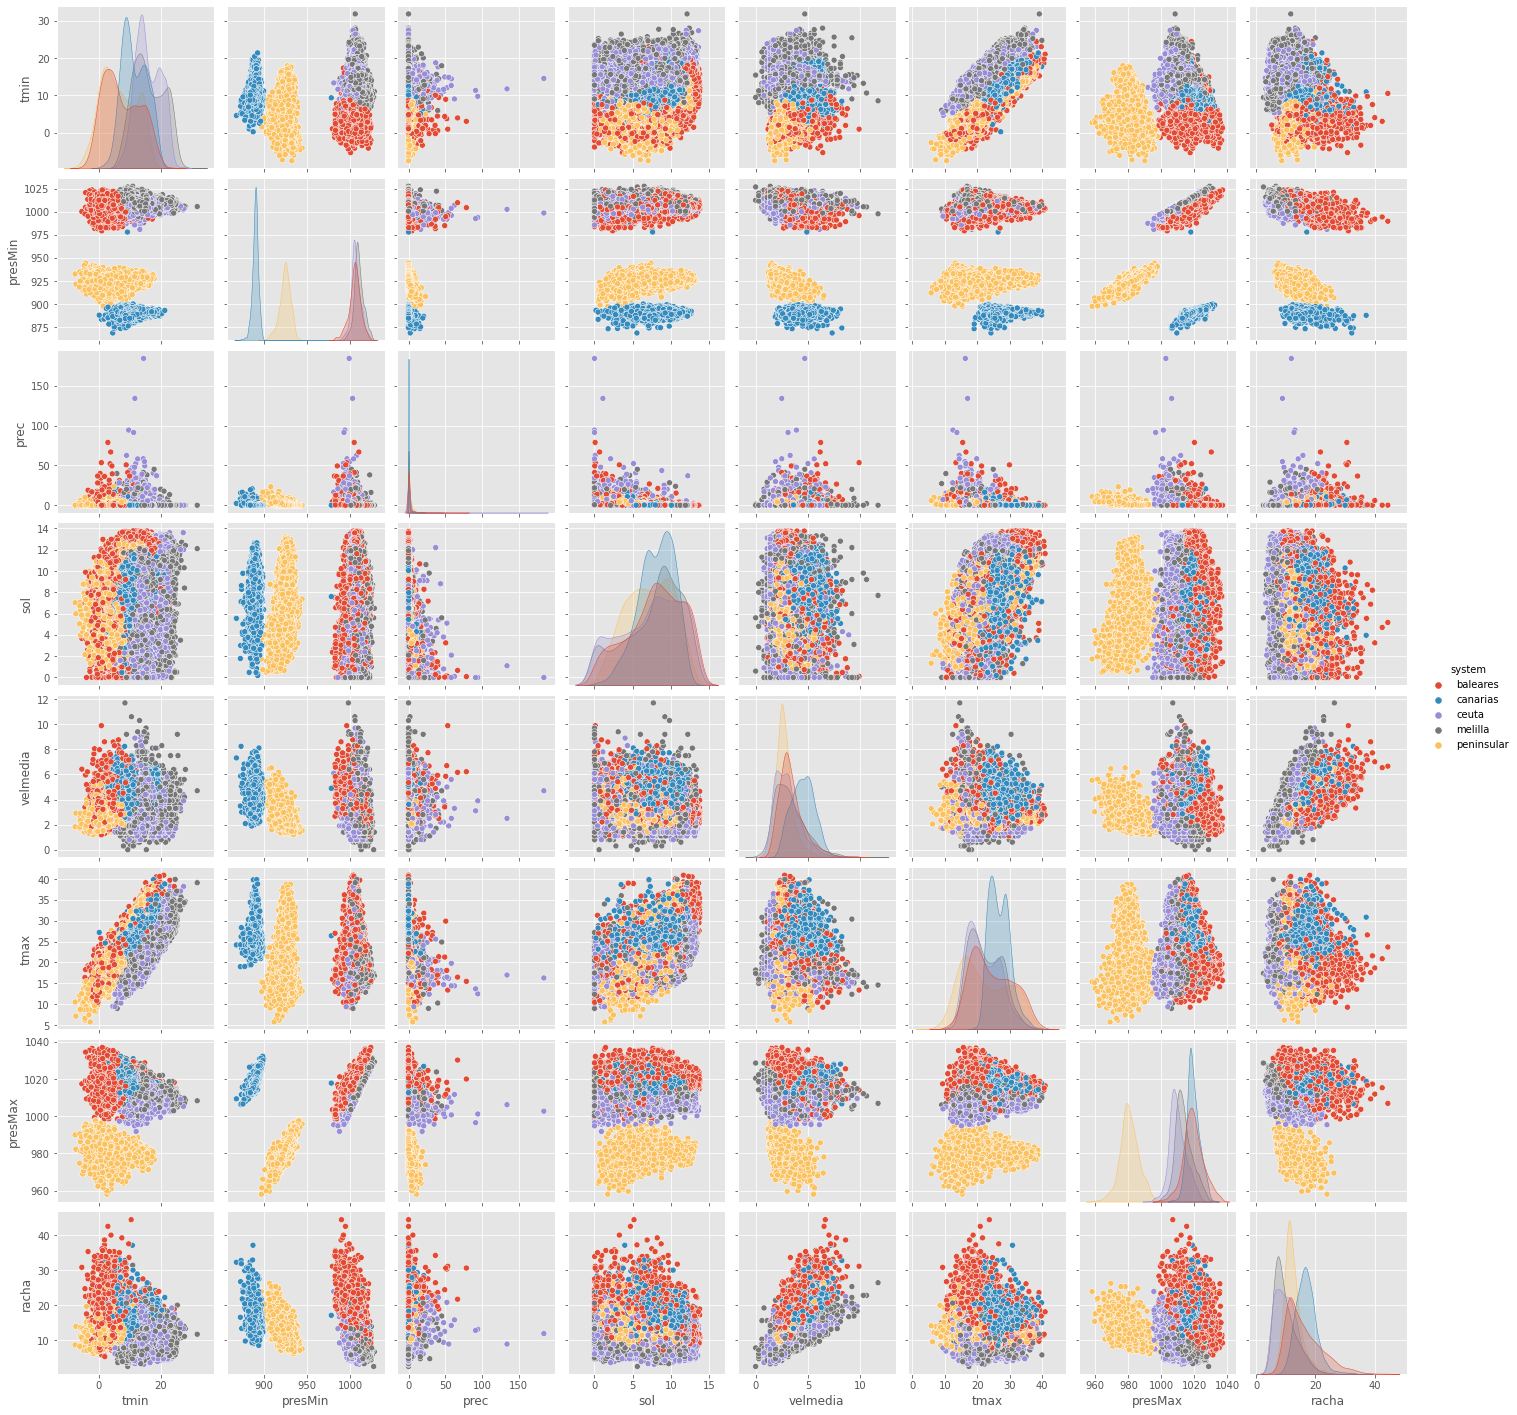

In [200]:
sns.pairplot(df_weather_system,vars=['tmin','presMin','prec','sol','velmedia','tmax','presMax','racha'	],hue='system',diag_kind='kde');


Vemos que en funcion de la presion (minima y maxima):
    - Hay 2 grupos muy claramente diferenciandos para temperaturas , velocidad del viento y horas de sol.
    - Y 2 grupos pero no tan claramente diferenciados para las precipitaciones
    - Se ve claramente un dato outlier para precipitaciones y otro para temperatura minima

In [201]:
df_Matrix_Corr=df_weather_system.corr()

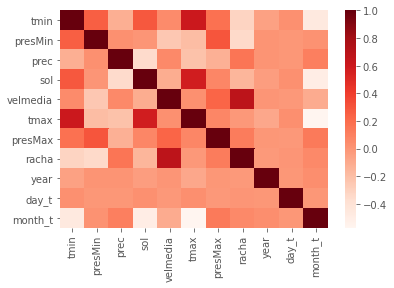

In [202]:
sns.heatmap(df_Matrix_Corr,cmap='Reds');

In [203]:
df_Matrix_Corr

,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha,year,day_t,month_t
tmin,1.000000,0.259455,-0.119119,0.292773,0.051317,0.602839,0.177960,-0.314080,-0.052209,0.023675,-0.458585
presMin,0.259455,1.000000,0.027154,0.002588,-0.246803,-0.186358,0.303019,-0.344805,0.005728,-0.003263,0.021785
prec,-0.119119,0.027154,1.000000,-0.345294,0.064866,-0.215208,-0.125596,0.162379,0.008102,-0.004388,0.113735
sol,0.292773,0.002588,-0.345294,1.000000,-0.106826,0.581340,0.075567,-0.152133,-0.034191,0.028018,-0.497356
velmedia,0.051317,-0.246803,0.064866,-0.106826,1.000000,0.023913,0.235913,0.683763,0.002941,-0.009383,-0.100309
tmax,0.602839,-0.186358,-0.215208,0.581340,0.023913,1.000000,0.073288,-0.008081,-0.082171,0.031072,-0.572531
presMax,0.177960,0.303019,-0.125596,0.075567,0.235913,0.073288,1.000000,0.124430,-0.001663,-0.011192,0.135177
racha,-0.314080,-0.344805,0.162379,-0.152133,0.683763,-0.008081,0.124430,1.000000,-0.018018,-0.000263,0.065932
year,-0.052209,0.005728,0.008102,-0.034191,0.002941,-0.082171,-0.001663,-0.018018,1.000000,-0.006065,0.036913
day_t,0.023675,-0.003263,-0.004388,0.028018,-0.009383,0.031072,-0.011192,-0.000263,-0.006065,1.000000,-0.002373


## Unir las 2 tablas  df_weather_features, df_ree_target
To get only the features and targets of the same dates and systems

In [191]:
df_weather_ree=pd.merge(df_weather_features,
                            df_ree_target, 
                             on=['fecha','x1_baleares','x1_canarias','x1_melilla','x1_peninsular'])

In [192]:
df_weather_ree.head()

,fecha,tmin,presMin,prec,sol,velmedia,tmax,presMax,racha,year,day_t,month_t,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular,Generacion_Mwh,x0_Carbón,x0_Ciclo combinado,x0_Cogeneración,x0_Eólica,x0_Fuel + Gas,x0_Hidroeólica,x0_Hidráulica,x0_Motores diésel,x0_Nuclear,x0_Otras renovables,x0_Residuos no renovables,x0_Residuos renovables,x0_Solar fotovoltaica,x0_Solar térmica,x0_Turbina de gas,x0_Turbina de vapor,x0_Turbinación bombeo,x2_No-Renovable,x2_Renovable
0,2016-01-01,3.300000,1009.300000,0.022222,1.940000,2.366667,18.900000,1024.900000,14.200000,2016,0.979530,0.866025,1.0,0.0,0.0,0.0,0.0,8814.678,3032.187,2277.467,69.160,11.053,0.0,0.000,0.000,1022.316,0.00,1.362,485.0490,485.0490,144.200,0.000,1286.835,0.000,0.000,8173.0140,641.6640
1,2016-01-01,7.900000,894.700000,0.000000,9.266667,2.781667,24.250000,1025.450000,10.400000,2016,0.979530,0.866025,0.0,1.0,0.0,0.0,0.0,20220.015,0.000,7124.185,0.000,383.526,0.0,11.815,9.163,6026.826,0.00,26.995,0.0000,0.0000,697.304,0.000,160.570,5779.631,0.000,19091.2120,1128.8030
2,2016-01-01,10.600000,1016.600000,0.000000,9.100000,1.700000,20.400000,1019.900000,5.600000,2016,0.979530,0.866025,0.0,0.0,0.0,1.0,0.0,479.011,0.000,0.000,0.000,0.000,0.0,0.000,0.000,447.061,0.00,0.000,15.9025,15.9025,0.145,0.000,0.000,0.000,0.000,462.9635,16.0475
3,2016-01-01,3.817021,921.165957,5.477102,2.231907,3.189763,16.440426,984.380851,16.361702,2016,0.979530,0.866025,0.0,0.0,0.0,0.0,1.0,537090.081,24401.321,48452.794,41918.271,199437.416,0.0,0.000,29281.000,0.000,162745.22,7169.124,3848.0700,1179.2320,8179.808,695.552,0.000,0.000,9782.273,291147.9490,245942.1320
4,2016-01-02,3.900000,1006.400000,0.000000,3.140000,4.488889,20.700000,1021.200000,23.300000,2016,0.918958,0.866025,1.0,0.0,0.0,0.0,0.0,9435.611,3269.033,2433.496,90.243,26.863,0.0,0.000,0.000,1189.254,0.00,2.335,458.4040,458.4040,194.499,0.000,1313.080,0.000,0.000,8753.5100,682.1010


In [194]:
df_weather_ree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7356 entries, 0 to 7355
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      7356 non-null   object 
 1   tmin                       7356 non-null   float64
 2   presMin                    7356 non-null   float64
 3   prec                       7270 non-null   float64
 4   sol                        7353 non-null   float64
 5   velmedia                   7355 non-null   float64
 6   tmax                       7356 non-null   float64
 7   presMax                    7356 non-null   float64
 8   racha                      7354 non-null   float64
 9   year                       7356 non-null   int64  
 10  day_t                      7356 non-null   float64
 11  month_t                    7356 non-null   float64
 12  x1_baleares                7356 non-null   float64
 13  x1_canarias                7356 non-null   float

In [ ]:
features_list=['tmin','presMin','prec','sol','tmax','presMax','racha','year','day_t','month_t','x1_baleares','x1_canarias','x1_ceuta','x1_melilla','x1_peninsular']

array_features=np.asarray(df_weather_ree[features_list].values).astype(np.float32)

array_target_tech=np.asarray(df_weather_ree[tech_names].values).astype(np.float32)

array_target_renov=np.asarray(df_weather_ree[renov_names].values).astype(np.float32)

array_target_total=df_weather_ree['Generacion_Mwh']

In [ ]:
array_target_tech

array([[3.032187e+03, 2.277467e+03, 6.916000e+01, ..., 1.286835e+03,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 7.124185e+03, 0.000000e+00, ..., 1.605700e+02,
        5.779631e+03, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 3.500000e-01,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.134440e+04, 4.974770e+04, 7.565680e+04, ..., 0.000000e+00,
        0.000000e+00, 1.376170e+04]], dtype=float32)

In [ ]:
array_target_renov

array([[  8173.014,    641.664],
       [ 19091.213,   1128.803],
       [   461.353,      0.   ],
       ...,
       [   507.158,      0.   ],
       [   513.656,      0.   ],
       [302243.7  , 390412.7  ]], dtype=float32)

In [ ]:
array_target_total

# Models

In [ ]:
from sklearn.linear_model import LinearRegression

# Para no predecir con datos de futuro separo los datos en train y test por fecha
train=df_weather_ree[df_weather_ree['fecha']<='2020-12-31']
test=df_weather_ree[df_weather_ree['fecha']>'2020-12-31']

X_train=train[features_list]
X_test=test[features_list]
y_train=train['Generacion_Mwh']
y_test=test['Generacion_Mwh']

X_train.info()

#reg_ln=LinearRegression()

#reg_ln.fit(X_train,y_train)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 9135 entries, 0 to 9134
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tmin           9129 non-null   float64
 1   presMin        9111 non-null   float64
 2   prec           9050 non-null   float64
 3   sol            9129 non-null   float64
 4   tmax           9129 non-null   float64
 5   presMax        9111 non-null   float64
 6   racha          9126 non-null   float64
 7   year           9135 non-null   int64  
 8   day_t          9135 non-null   float64
 9   month_t        9135 non-null   float64
 10  x1_baleares    9135 non-null   float64
 11  x1_canarias    9135 non-null   float64
 12  x1_ceuta       9135 non-null   float64
 13  x1_melilla     9135 non-null   float64
 14  x1_peninsular  9135 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 1.1 MB


AttributeError: ignored

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV



reg_KN=GridSearchCV(KNeighborsRegressor(),param_grid={"n_neighbors":np.arange(3,15)},scoring='neg_mean_absolute_error')
reg_KN.fit(X_train,y_train)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg_DT=GridSearchCV(DecisionTreeRegressor(),param_grid={'max_depth':range(3,100)},scoring='neg_mean_absolute_error')
reg_DT.fit(X_train,y_train)

In [ ]:
from keras.callbacks import TensorBoard
tensorboard_ree=TensorBoard(log_dir='logs')

%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 640), started 0:26:18 ago. (Use '!kill 640' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
from keras import models,layers, metrics, losses,optimizers

neuronal_net=models.Sequential()

neuronal_net.add(layers.Dense(32,input_shape=(15,)))
neuronal_net.add(layers.Dense(32,activation='relu'))
neuronal_net.add(layers.Dense(32,activation='relu'))
neuronal_net.add(layers.Dense(1))

neuronal_net.compile(optimizer=optimizers.RMSprop(),loss=losses.mean_absolute_error, metrics=[metrics.mean_absolute_percentage_error])

neuronal_net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                512       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
neuronal_net.fit(array_features,array_target_total,batch_size=64,epochs=60,callbacks=[tensorboard_ree],validation_split=.1)

Epoch 1/60
135/135 [==============================] - 2s 8ms/step - loss: 145939.4655 - mean_absolute_percentage_error: 101.9081 - val_loss: 144280.6719 - val_mean_absolute_percentage_error: 99.9745
Epoch 2/60
135/135 [==============================] - 0s 3ms/step - loss: 141624.5610 - mean_absolute_percentage_error: 99.9682 - val_loss: 144280.1719 - val_mean_absolute_percentage_error: 99.9342
Epoch 3/60
135/135 [==============================] - 0s 3ms/step - loss: 142958.1157 - mean_absolute_percentage_error: 99.9273 - val_loss: 144279.5000 - val_mean_absolute_percentage_error: 99.8785
Epoch 4/60
135/135 [==============================] - 0s 3ms/step - loss: 149979.1351 - mean_absolute_percentage_error: 99.8728 - val_loss: 144278.6094 - val_mean_absolute_percentage_error: 99.8076
Epoch 5/60
135/135 [==============================] - 0s 3ms/step - loss: 142492.3690 - mean_absolute_percentage_error: 99.8056 - val_loss: 144277.5625 - val_mean_absolute_percentage_error: 99.7217
Epoch 6/6

# Evaluation

Crear tabla de resultados.

In [ ]:
print(reg_ln.score)


In [ ]:
print(reg_KN.best_score_)
print(reg_KN.best_params_)

In [ ]:
print(reg_DT.best_score_)
print(reg_DT.best_params_)

# Interfaz y ploteado


In [ ]:
# ver follium para pintar 5 puntos y dentro de cada uno, input de datos metereologicos.